# Examples of use of `sdeparams`

#### Imports

In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint
from scipy.optimize import differential_evolution

import sdeparams

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='colorblind')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

import warnings
warnings.filterwarnings('ignore')

## SIR model

We estimate the parameters for a susceptible-infected-recovered model with a constant population size $N$. The system is defined by $\mathbf{x}=(S/N, I/N)=(s, i)$, where $S$ and $I$ (resp. $s$ and $i$) are the numbers (resp. fractions) of susceptible and infected individuals in the population. The relevant matrices are given by

$$\mathbf{A}(\mathbf{x}) = \left(\begin{array}{c}-\beta s i \\ \beta s i - \gamma i\end{array}\right)$$

$$\mathbf{B}(\mathbf{x}) = \left(\begin{array}{c c} \beta s i & -\beta s i \\ -\beta s i & \beta s i + \gamma i\end{array}\right)$$

$$\mathbf{J}(\mathbf{x}) = \left(\begin{array}{c c} -\beta i & -\beta s \\ \beta i & \beta s - \gamma\end{array}\right)$$

### Fully observed system

We assume that we have data for both $s$ and $i$ and estimate $\beta$, $\gamma$ and $N$. Note that all arguments following the state vector in $\mathbf{A}$, $\mathbf{B}$ and $\mathbf{J}$ are assumed to be parameters to be estimated.

In [2]:
ndim = 2

def A(x, *params):
    beta, gamma, N = params # if the system size is estimated, it should always go at the end
    s, i = np.maximum(x, np.zeros(ndim))
    return np.array([-beta*s*i, beta*s*i - gamma*i])

def B(x, *params):
    beta, gamma, N = params # if the system size is estimated, it should always go at the end
    s, i = np.maximum(x, np.zeros(ndim))
    return np.array([[beta*s*i, -beta*s*i],[-beta*s*i, beta*s*i + gamma*i]])

def J(x, *params):
    beta, gamma, N = params # if the system size is estimated, it should always go at the end
    s, i = np.maximum(x, np.zeros(ndim))
    return np.array([[-beta*i, -beta*s],[beta*i, beta*s-gamma]])

The function `'path'` below returns one realisation of the process. This is only for illustration purposes, since we obtain artificial data from it.

In [3]:
def path(x, t, *params):
    dt = t[1]-t[0]
    
    N = params[-1] # # if the system size is estimated, it should always go at the end
    
    x_t = []
    
    if isinstance(x, float) or isinstance(x, int):
        for  time in t:
            x_t.append(x)
            y = A(x, *params)*dt + np.sqrt(dt*B(x, *params)/N)*np.random.normal()
            x += y
    else:
        n_dim = len(x)
        x_0 = x.copy()
        for time in t:
            x_t.append(x_0.copy())
            y = A(x_0, *params)*dt + np.sqrt(dt/N)*np.random.multivariate_normal(np.zeros(n_dim), B(x_0, *params))
            x_0 += y
            
    return np.array(x_t)

#### 'Real' parameters

In [4]:
beta = 3.5
gamma = 1.2
N = 250

# Initial condition with S=200, i=1
x0 = [200./N, 1./N]

#### 'Real' process

In [5]:
dt = 0.0005

t_full = np.arange(0., 7., dt)
x_real = path(x0, t_full, beta, gamma, N)

We take 100 datapoints at different time intervals

In [6]:
measurements = np.sort(np.random.choice(range(len(t_full)), 100, replace=False))
artificial_timepoints = t_full[measurements]
artificial_data = x_real[measurements]

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 <a list of 11 Text yticklabel objects>)

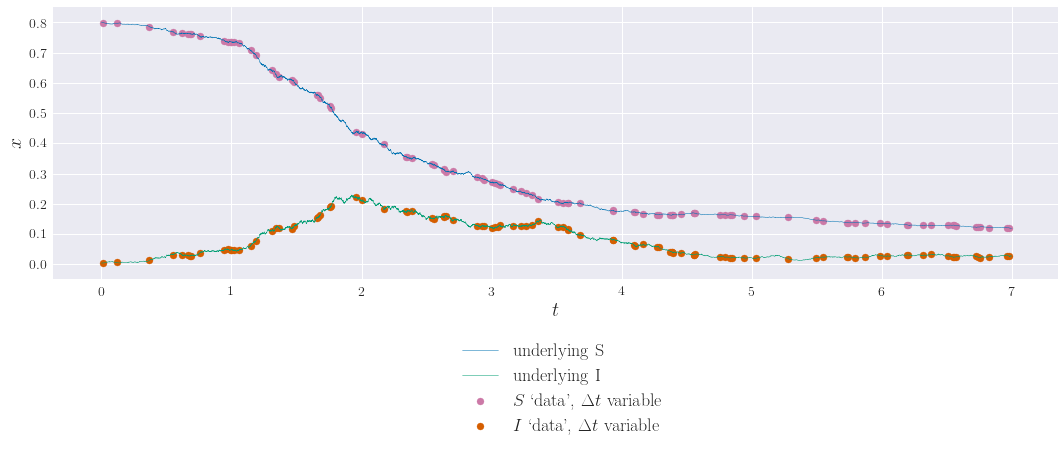

In [7]:
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(t_full, x_real[:,0], linewidth=0.5, label=r"underlying S")
ax.plot(t_full, x_real[:,1], linewidth=0.5, label=r"underlying I")
ax.scatter(artificial_timepoints, artificial_data[:, 0], color=colours[3], label=r"$S$ `data', $\Delta t$ variable")
ax.scatter(artificial_timepoints, artificial_data[:, 1], color=colours[2], label=r"$I$ `data', $\Delta t$ variable")
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.legend(fontsize=18, loc=(0.4,-0.6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Constructing the `Zimmer` object

We use the default optional arguments.

In [8]:
observations = (artificial_data, artificial_timepoints)

zimmer = sdeparams.Zimmer(A, B, J, observations, ndim)

#### Estimation using Differential Evolution

In [9]:
bounds = [(1., 5.), (0., 5.), (100, 500)]

estimation = differential_evolution(zimmer.costfn, bounds)

params_estim = tuple(estimation.x)

In [10]:
params_table = {'process': ['real', 'estimated'], r'$\beta$': [beta, params_estim[0]], r'$\gamma$': [gamma, params_estim[1]], r'$N$': [N, params_estim[2]]}
params_table = pd.DataFrame(params_table)
params_table.set_index(['process'])

$\beta$  $\gamma$         $N$
process                                  
real       3.500000  1.200000  250.000000
estimated  3.624434  1.244201  270.372099

#### Reconstructed process

In [11]:
x_estim = zimmer.reconstruct(params_estim)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 <a list of 11 Text yticklabel objects>)

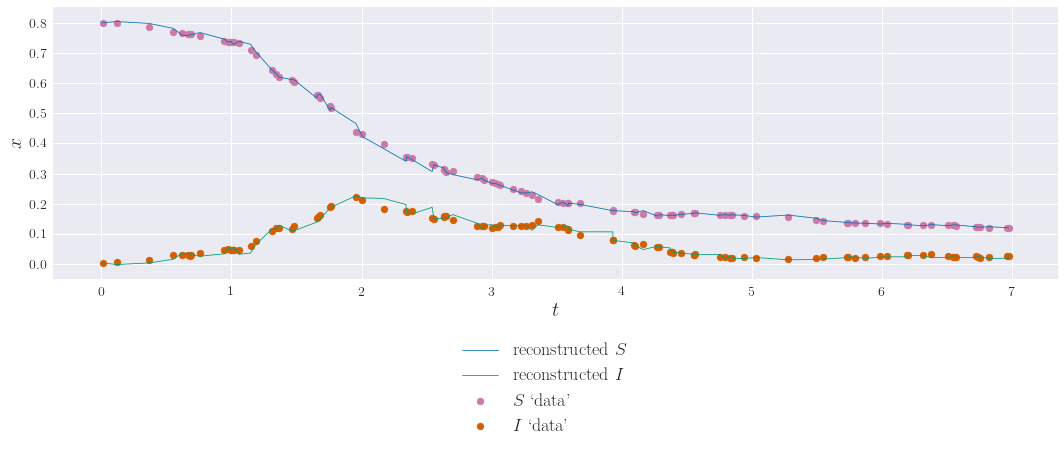

In [12]:
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(artificial_timepoints, x_estim[:,0], linewidth=0.8, label=r"reconstructed $S$")
ax.plot(artificial_timepoints, x_estim[:,1], linewidth=0.8, label=r"reconstructed $I$")
ax.scatter(artificial_timepoints, artificial_data[:, 0], color=colours[3], label=r"$S$ `data'")
ax.scatter(artificial_timepoints, artificial_data[:, 1], color=colours[2], label=r"$I$ `data'")
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.legend(fontsize=18, loc=(0.4,-0.6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Partially observed system

Let's consider the case when we only have data for $i$. This time, we estimate $s_0=s(t=0)$, $\beta$, $\gamma$ and $N$.

Note that $\mathbf{A}$, $\mathbf{B}$ and $\mathbf{J}$ are rearranged so that the observed variable goes first. At the same time, the initial condition for the unobserved variable goes at the beginning of the list of parameters to be estimated.

In [13]:
def A(x, *params):
    s0, beta, gamma, N = params # initial condition for unobserved variable goes first
    i, s = np.maximum(x, np.zeros(ndim)) # observed variable goes first in state vector
    return np.array([beta*s*i - gamma*i, -beta*s*i])

def B(x, *params):
    s0, beta, gamma, N = params # initial condition for unobserved variable goes first
    i, s = np.maximum(x, np.zeros(ndim)) # observed variable goes first in state vector
    return np.array([[beta*s*i + gamma*i, -beta*s*i],[-beta*s*i, beta*s*i]])

def J(x, *params):
    s0, beta, gamma, N = params # initial condition for unobserved variable goes first
    i, s = np.maximum(x, np.zeros(ndim)) # observed variable goes first in state vector
    return np.array([[beta*s-gamma, beta*i],[-beta*s, -beta*i]])

#### 'Real' parameters

Same as before, with $s_0=200/N=0.8$.

#### Constructing the `Zimmer` object

This time the number of observed variables is smaller than the dimensionality of the system.

In [14]:
observations = (artificial_data[:,1], artificial_timepoints) # we only use the infected component of the artificial data

zimmer = sdeparams.Zimmer(A, B, J, observations, ndim, n_obs=1)

#### Estimation using Differential Evolution

In [19]:
bounds = [(0.5, 1.), (1., 5.), (0., 5.), (100, 500)]

estimation = differential_evolution(zimmer.costfn, bounds)

params_estim = tuple(estimation.x)

In [20]:
params_table = {'process': ['real', 'estimated'], r'$s_0$': [x0[0], params_estim[0]], r'$\beta$': [beta, params_estim[1]], r'$\gamma$': [gamma, params_estim[2]], r'$N$': [N, params_estim[3]]}
params_table = pd.DataFrame(params_table)
params_table.set_index(['process'])

$s_0$   $\beta$  $\gamma$         $N$
process                                          
real       0.8000  3.500000  1.200000  250.000000
estimated  0.8217  4.010342  1.339921  284.993598

#### Reconstructed process

In [21]:
x_estim = zimmer.reconstruct(params_estim)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 7 Text yticklabel objects>)

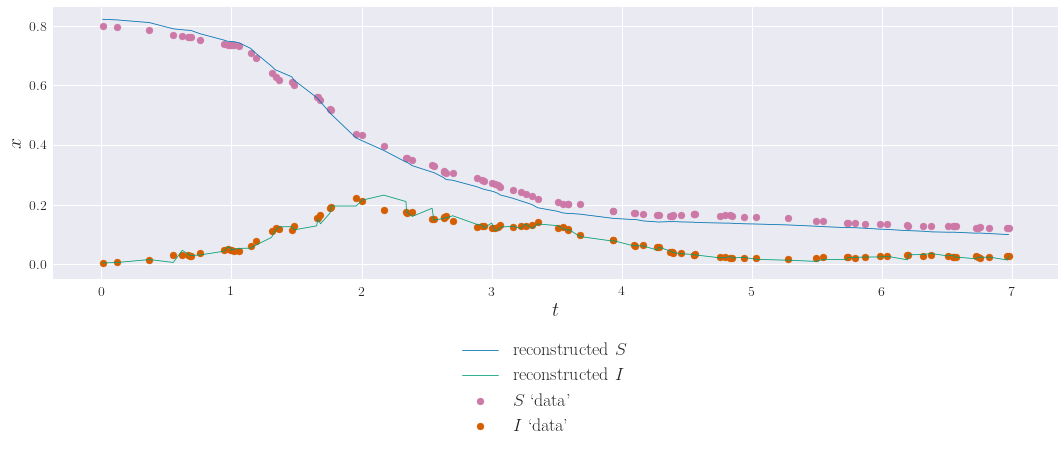

In [22]:
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(artificial_timepoints, x_estim[:,1], linewidth=0.8, label=r"reconstructed $S$")
ax.plot(artificial_timepoints, x_estim[:,0], linewidth=0.8, label=r"reconstructed $I$")
ax.scatter(artificial_timepoints, artificial_data[:, 0], color=colours[3], label=r"$S$ `data'")
ax.scatter(artificial_timepoints, artificial_data[:, 1], color=colours[2], label=r"$I$ `data'")
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.legend(fontsize=18, loc=(0.4,-0.6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Internal methods and manual specification of the objective function: SEIR model fitted to norovirus data

We consider the system from Eq. (31) of [Buckingham-Jeffery *et al.* (2018)](https://www.sciencedirect.com/science/article/pii/S0025556417303644) for the norovirus outbreak reported in [Vivancos *et al.* (2010)](https://doi.org/10.1016/j.jinf.2010.03.018). Here, $\mathbf{X}=(S,E,I)$ and

$$\mathbf{A}(\mathbf{X}) = \left(\begin{array}{c}-\beta S I/N \\ \beta S I/N - \omega E \\ \omega E - \gamma I\end{array}\right)$$

$$\mathbf{B}(\mathbf{x}) = \left(\begin{array}{c c} \beta S I/N & -\beta S I/N & 0 \\ -\beta S I/N & \beta S I/N + \omega E & -\omega E \\ 0 & -\omega E & \omega E + \gamma I\end{array}\right)$$

$$\mathbf{J}(\mathbf{x}) = \left(\begin{array}{c c} -\beta I/N & 0 & -\beta S/N \\ \beta I/N & -\omega & \beta S/N \\ 0 & \omega & - \gamma\end{array}\right)$$


The data correspond to the cumulative incidence $S_0-S(t)$ with $S_0\neq N$. We estimate $S_0$, $\beta$ and $\gamma$, with $\omega=2$

In [23]:
ndim = 3
N = 1714

def A(x, *params):
    s0, beta, gamma = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    return np.array([-beta*s*i/N, beta*s*i/N - w*e, w*e - gamma*i])

def B(x, *params):
    s0, beta, gamma = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    return np.array([[beta*s*i/N, -beta*s*i/N, 0.], [-beta*s*i/N, beta*s*i/N + w*e, -w*e], [0., -w*e, w*e + gamma*i]])

def J(x, *params):
    s0, beta, gamma = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    return np.array([[-beta*i/N, 0., -beta*s/N], [beta*i/N, -w, beta*s/N], [0., w, -gamma]])

#### Defining the LNA

Above, this is done internally when constructing a Zimmer object. It is exactly the same definition; perhaps this can be automated.

In [24]:
def LNA(x, t, *params):
    y = np.maximum(x[:ndim], np.zeros(ndim))
    x_det = A(y, *params)
    Xi = np.reshape(x[ndim:], (ndim,ndim))
    Jac = J(y, *params)
    dXidt = np.dot(Jac, Xi) + np.dot(Xi, Jac.transpose()) + B(y, *params)

    return np.concatenate((x_det, dXidt.flatten()))

#### Specifying the objective function

The following are also handled internally when using a `Zimmer` object. Given a set of parameter values:
- `'likelihood_next'` returns the PDF of the approximation evaluated at the real data point at time $t_{i+1}$
- `'costfn'` returns the value of the objective function
- `'draw_next'` returns a reconstructed data point at time $t_{i+1}$ given the data at time $t_i$
- `'reconstruct'` returns the array of reconstructed data points

The mandatory arguments for `likelihood_next` and `draw_next` below are:
1. tuple of parameter values
2. LNA
3. current datapoint
4. next datapoint
5. current timepoint
6. next timepoint

The optional parameters are self-explanatory. Note that since the problem is specified in terms of numbers of individuals, rather than fractions, the system size has been normalised to 1 for the calls to `likelihood_next` and `draw_next`&mdash;this helps to prevent the additional factor $1/N$ these functions apply.

In [25]:
n_obs = 1

def costfn(params, *measurements):
    data, times = measurements
    
    s0 = params[0]
    
    data = s0 - data # this is the step that cannot be handled automatically and calls for a manual specification
    now = np.append(data[0], np.array([0,1])) # initial condition (S_0, 0, 1)
    
    total = 0.
    for i in range(len(data)-1):
        estimation = sdeparams.likelihood_next(params, LNA, now, data[i+1], times[i], times[i+1], n_obs=n_obs, estimate_N=False, N=1)
        total -= np.log(estimation[0])
        
        now = np.append(data[i+1], estimation[1])
        
    return total

In [26]:
def reconstruct(params, measurements):

    data, times = measurements

    s0 = params[0]
    
    data = s0 - data # this is the step that cannot be handled automatically and calls for a manual specification
    now = np.append(data[0], np.array([0,1])) # initial condition (S_0, 0, 1)
    
    x_t = [now]
    for i in range(len(data)-1):
        next_point = sdeparams.draw_next(params, LNA, now, data[i+1], times[i], times[i+1], n_obs=n_obs, estimate_N=False, N=1)
        
        next_point = np.maximum(next_point, np.zeros(ndim))
        
        x_t.append(next_point)
        
        if ndim > n_obs:
            now = np.append(data[i+1], next_point[n_obs:])
        else:
            now = data[i+1]
    return np.array(x_t)

#### Data and estimation

In [35]:
data = pd.read_csv('data_norovirus.csv', index_col='day')

data

diagnosed  cumulative
day                       
0            0           0
1            0           0
2            1           1
3            2           3
4            3           6
5           18          24
6           36          60
7           24          84
8           34         118
9           18         136
10          25         161
11          15         176
12          16         192
13           3         195
14           0         195

In [36]:
observations = (data.cumulative.values, data.index.values)

In [37]:
bounds = [(196, N), (0., 30.), (0., 10.)]

w=2.

estimation = differential_evolution(costfn, bounds, args=observations)

params_estim = tuple(estimation.x)

In [38]:
params_table = {'process': ['estimated'], r'$S_0$': [params_estim[0]], r'$\beta$': [params_estim[1]], r'$\gamma$': [params_estim[2]]}
params_table = pd.DataFrame(params_table)
params_table.set_index(['process'])

$S_0$    $\beta$  $\gamma$
process                                  
estimated  246.05049  21.471339  1.464679

#### Reconstructed process

In [39]:
x_estim = reconstruct(params_estim, observations)

(0, 251.0504900112026)

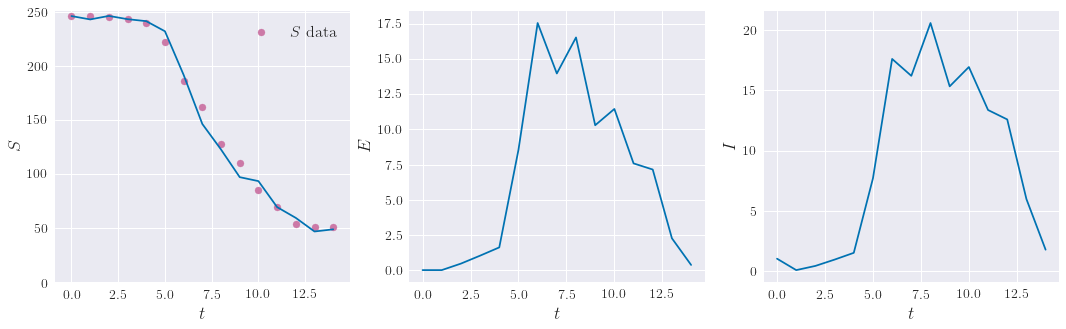

In [40]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
fig, axes = plt.subplots(1,3, figsize=(18,5))
labels=[r'$S$',r'$E$',r'$I$']
for i, ax in enumerate(axes):
    ax.plot(observations[1], x_estim[:,i])
    ax.set_xlabel(r'$t$', fontsize=18)
    ax.set_ylabel(labels[i], fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

axes[0].scatter(observations[1], params_estim[0]-observations[0], color=colours[3], label=r"$S$ data")
axes[0].legend(fontsize=16)
axes[0].set_ylim(0,params_estim[0]+5)

#### Objective function for a grid of parameters

Below, we fix $S_0=246$.

In [41]:
betas = np.linspace(13.,28.,50)
gammas = np.linspace(0.7,2.,50)

likelihood = []
for b in betas:
    for g in gammas:
        likelihood.append([b, g, np.exp(-costfn((246,b,g), *observations))])
likelihood=np.array(likelihood)

In [42]:
locations = pd.DataFrame(likelihood, columns=['beta', 'gamma', 'likelihood'])
locations.likelihood = locations.likelihood/(locations.likelihood.sum())

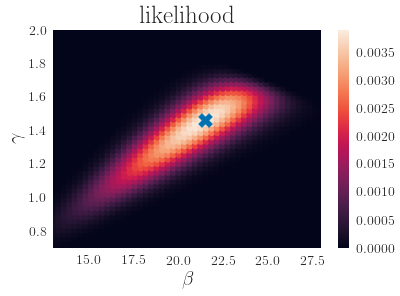

In [44]:
points = plt.scatter(locations.beta, locations.gamma, c=locations.likelihood/(locations.likelihood.sum()), s=50)
plt.scatter([params_estim[1]],[params_estim[2]], marker='X', s=200)
plt.xlim(13,28)
plt.ylim(0.7,2.)
plt.xlabel(r'$\beta$', fontsize=20)
plt.ylabel(r'$\gamma$', fontsize=20)
plt.title(r'likelihood', fontsize=25)
plt.colorbar(points)

**Note:** We repeat this because the interactive plot below does not accept more than 5000 rows of data.

In [45]:
betas = np.linspace(13.,28.,18)
gammas = np.linspace(0.7,2.,18)

likelihood = []
for b in betas:
    for g in gammas:
        likelihood.append([b, g, np.exp(-costfn((246,b,g), *observations))])
likelihood=np.array(likelihood)

In [46]:
locations = pd.DataFrame(likelihood, columns=['beta', 'gamma', 'likelihood'])
locations.likelihood = locations.likelihood/(locations.likelihood.sum())

locations['id'] = locations.index.values.astype(int)

In [47]:
results_s = pd.DataFrame({'t': observations[1]})
results_e = pd.DataFrame({'t': observations[1]})
results_i = pd.DataFrame({'t': observations[1]})

for i, x in locations.iterrows():
    
    params = (246, x.beta, x.gamma)

    reconstructed = reconstruct(params, observations)
    
    results_s[str(x.id)] = reconstructed[:,0]
    results_e[str(x.id)] = reconstructed[:,1]
    results_i[str(x.id)] = reconstructed[:,2]
    
results_s = results_s.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'S'})
results_s.id = results_s.id.astype(float).astype(int)

results_e = results_e.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'E'})
results_e.id = results_e.id.astype(float).astype(int)

results_i = results_i.melt('t').rename(columns={'t': 'time', 'variable': 'id', 'value': 'I'})
results_i.id = results_i.id.astype(float).astype(int)

In [48]:
full = pd.merge(pd.concat([results_s, results_e.E, results_i.I], axis=1), locations, on='id')

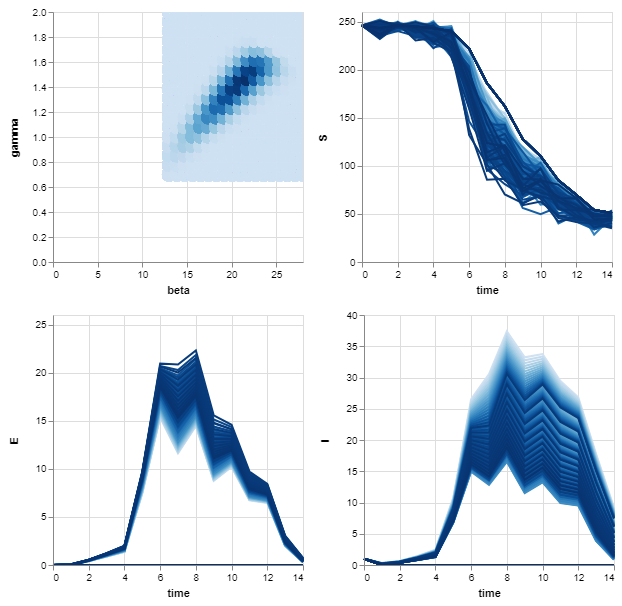

In [50]:
import altair as alt
alt.renderers.enable('notebook')

selector = alt.selection_single(empty='all', fields=['id'])

points = alt.Chart(full).mark_point(filled=True, size=200).encode(
    x='beta',
    y='gamma',
    color=alt.condition(selector, 'likelihood', alt.value('white'), legend=None),
).properties(
    selection=selector,
    width=250, height=250
).interactive()

timeseries_s = alt.Chart(full).mark_line().encode(
    x='time',
    y=alt.Y('S', scale=alt.Scale(domain=(0, 250))),
    color=alt.Color('id:O', legend=None)
).transform_filter(
    selector
).properties(
    selection=selector,
    width=250, height=250
)

timeseries_e = alt.Chart(full).mark_line().encode(
    x='time',
    y=alt.Y('E', scale=alt.Scale(domain=(0, 25))),
    color=alt.Color('id:O', legend=None)
).transform_filter(
    selector
).properties(
    selection=selector,
    width=250, height=250
)

timeseries_i = alt.Chart(full).mark_line().encode(
    x='time',
    y=alt.Y('I', scale=alt.Scale(domain=(0, 40))),
    color=alt.Color('id:O', legend=None)
).transform_filter(
    selector
).properties(
    selection=selector,
    width=250, height=250
)

alt.vconcat(alt.hconcat(points, timeseries_s), alt.hconcat(timeseries_e, timeseries_i)
)